Testando edit Roberto github command line / agora no site do github

In [43]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter

import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple, name_data
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle
from filters import filter_butter
from fast_open_data import open_data_filter

# -> Escolher voluntário e chave

* open_data_filter(Voluntary => 1 até 90, key => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2' ...)

In [44]:
S, R, L = open_data_filter(52, key = 'S1_Synched')
S1, R1, L1 = open_data_filter(23, key = 'S1_Synched')

In [45]:
# dados para voluntário 52
estimated_R = [ 30, 330, 585, 740]
estimated_L = [ 100, 330, 595, 790]
estimated_S = [ 140, 264, 365, 570, 647, 725]

sequece_R_L = [1,2,1,3,1]
sequece_S = [1,2,3,1,2,3,1]

In [46]:
sequence = sequece_S.copy()
sequence.extend(sequece_R_L) 
classes = np.unique(sequence)

In [47]:
def sep_modo(data, estimated_data, modo_sequence, classes):
    
    
    V_seq = np.zeros(len(modo_sequence))
    Var_seq = np.zeros(len(modo_sequence))
    V_modo = np.zeros(len(classes))
    Var_modo = np.zeros(len(classes))
    
    modo = np.zeros((data.shape))

    for i in range(len(modo_sequence)):
        if i == 0:
            modo[:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[:estimated_data[i]]))
            Var_seq[i] = np.var(np.diff(data[:estimated_data[i]]))
            
            
        elif i == (len(estimated_data)):
            modo[estimated_data[i-1]:] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:]))
            Var_seq[i] = np.var(np.diff(data[estimated_data[i-1]:]))
        
        else:
            modo[estimated_data[i-1]:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:estimated_data[i]]))
            Var_seq[i] = np.var(np.diff(data[estimated_data[i-1]:estimated_data[i]]))
                    
    for n in range(len(classes)):
        idx = np.where(np.array(modo_sequence) == n+1)[0]
        V_modo[n] = np.mean(np.array(V_seq)[idx])
        Var_modo[n] = np.mean(np.array(Var_seq)[idx])
        
    return modo, V_seq, V_modo, Var_seq, Var_modo
            

In [48]:
modo, V_seq, V_modo, Var_seq, Var_modo = sep_modo(S, estimated_S, sequece_S, classes)

In [49]:
modo_S, V_seq_S, V_modo_S, Var_seq_S, Var_modo_S = sep_modo(S, estimated_S, sequece_S, classes)
modo_L, V_seq_L, V_modo_L, Var_seq_L, Var_modo_L = sep_modo(L, estimated_L, sequece_R_L, classes)
modo_R, V_seq_R, V_modo_R, Var_seq_R, Var_modo_R = sep_modo(R, estimated_R, sequece_R_L, classes)

O sinal do movimento está na escala de 0 à 3 para facilitar a visualização dos modos em relação ao sinal.

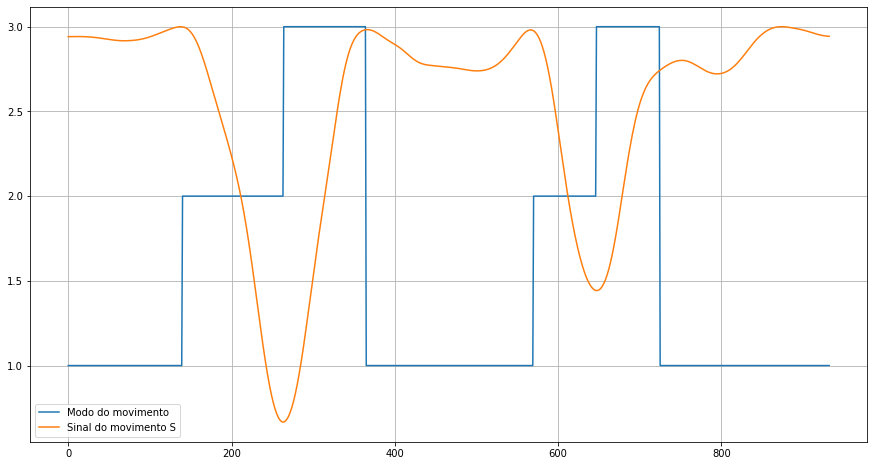

In [50]:
plt.figure(figsize=[15,8])
plt.plot(modo, label = 'Modo do movimento')
plt.plot(S/max(S)*3, label = 'Sinal do movimento S')
plt.legend()
plt.grid()
plt.show()

In [51]:
for i in range(len(V_seq)):
    print('Modo: ', sequece_S[i], '--> Média: ', round(V_seq[i], 4))
    
for i in range(len(Var_seq)):
    print('Modo: ', sequece_S[i], '--> Variância: ', round(Var_seq[i], 4))

Modo:  1 --> Média:  0.0117
Modo:  2 --> Média:  -0.5316
Modo:  3 --> Média:  0.649
Modo:  1 --> Média:  -0.0006
Modo:  2 --> Média:  -0.5651
Modo:  3 --> Média:  0.4725
Modo:  1 --> Média:  0.027
Modo:  1 --> Variância:  0.0007
Modo:  2 --> Variância:  0.0749
Modo:  3 --> Variância:  0.106
Modo:  1 --> Variância:  0.0073
Modo:  2 --> Variância:  0.0758
Modo:  3 --> Variância:  0.0765
Modo:  1 --> Variância:  0.0058


Aplicando as médias para cada uma das fases dos movimentos, temos que: 

In [52]:
for i in range(len(V_modo)):
    print('Modo: ', classes[i], '--> Média: ', round(V_modo[i], 4))

for i in range(len(Var_modo)):
    print('Modo: ', classes[i], '--> Variância: ', round(Var_modo[i], 4))

Modo:  1 --> Média:  0.0127
Modo:  2 --> Média:  -0.5484
Modo:  3 --> Média:  0.5607
Modo:  1 --> Variância:  0.0046
Modo:  2 --> Variância:  0.0754
Modo:  3 --> Variância:  0.0912


In [53]:
def generate_model(data, modo, V_modo):
    
    data_model = np.zeros(S.shape)
    for i in range(len(data)):
        if i == 0:
            data_model[i] = data[i]
        else:
            data_model[i] = data[i-1] + V_modo[int(modo[i])-1]
    
    return data_model

In [54]:
data_model = generate_model(S, modo, V_modo)

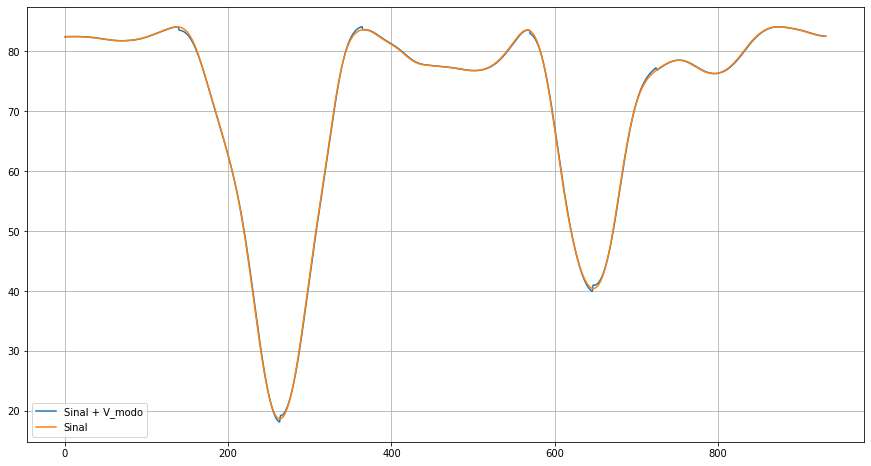

In [55]:
plt.figure(figsize=[15,8])
plt.plot(data_model, label = 'Sinal + V_modo')
plt.plot(S, label = 'Sinal')
plt.legend()
plt.grid()
plt.show()

Separando os modos para os dados de Spine

# Aplicar filtro de Kalman

In [56]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import time

Descrever matematicamente a aplicação do filtro de Kalman
\
Predição: 

$ x(k/k-1) = Fk x(k/k-1) + Bk uk $

$ Pk/k-1 = Fk Pk-1/k-1 Fk.T + Qk $


Atualização: 



In [57]:
def filter_kalman(data, vel, var, c):

    dt = 1
    r = 0.5   #.R = 5
    p = 10.  #.P = 1000.
    
    my_filter = KalmanFilter(dim_x=2, dim_z=1)

    my_filter.x = np.array([data[0],vel])       # initial state (location and velocity)

    my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix

    my_filter.H = np.array([[1.,0.]])    # Measurement function
    my_filter.P *= p                 # covariance matrix
    my_filter.R = r                      # state uncertainty
    my_filter.Q = Q_discrete_white_noise(2, dt, var) # process uncertainty
        
    i = 0
    data_out = np.zeros(data.shape)
    while i < len(data):
        my_filter.predict()
        my_filter.update(data[i])
        
        # do something with the output
        x = my_filter.x
        data_out[i] = x[0]
        i = i + 1
    
    return data_out

In [58]:
S_filter = np.zeros(S.shape)

i = 0
j = 0
S_sep = []
for n in range(len(classes)):
    S_sep.append([])
while j < len(modo):
    i = j 
    cur_class = modo[i].astype(int)
    
    while modo[j] == cur_class:
        j += 1
        if j >= len(S):
            j = len(S)
            break
            
    idx = np.where(classes==cur_class)[0][0]
    S_sep[idx].append(S[i:j])

    S_filter[i:j] = filter_kalman(S[i:j], V_modo[idx], Var_modo[idx], cur_class)
    
    

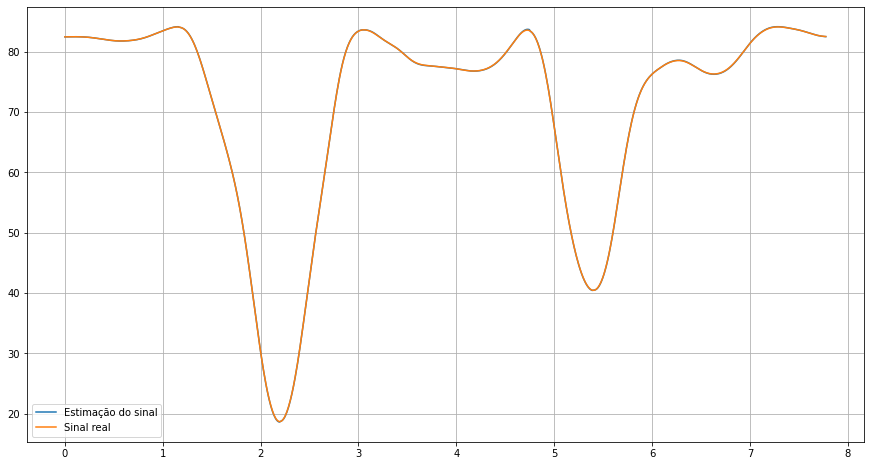

In [59]:
f_name = 'C:/Users/User/OneDrive/TCC/ema_motion_analysis_imu/Imagens/'

t = np.linspace(0, len(S) / 120, len(S))
plt.figure(figsize=[15,8])
plt.plot(t[:], S_filter[:], label = 'Estimação do sinal')
plt.plot(t[:], S[:], label = 'Sinal real')
plt.legend()
plt.grid()
#plt.savefig(f_name + 'Zoom no filtro de kalman.png')
plt.show()

In [60]:
from filterpy.common import kinematic_kf
from filterpy.kalman import IMMEstimator

### Essa matriz de transição deve ser calculada para transição geral do sistema, ou seja, com dados do tronco e perna

In [61]:
def transition_matrix(modo, classes):
    
    transitions = np.zeros(modo.shape)
    not_transitions = np.zeros(modo.shape)
    transition_matrix = np.zeros([len(classes), len(classes)])
    

    for i in range(len(classes)):
        for j in range(len(classes)):
            for n in range(len(modo)-1):
                t = n + 1
                
                if (modo[t-1] == i+1 and modo[t] == j+1):
                    transitions[t] = 1

                else:
                    transitions[t] = 0

                if modo[t] == i+1:
                    not_transitions[t] = 1

                else:
                    not_transitions[t] = 0
            
            transition_matrix[i, j] = np.sum(transitions)/np.sum(not_transitions)
            #plt.plot(transitions, label = 'Transitions: '+str(i)+','+str(j))
            #plt.legend()
            #plt.show()
            #plt.plot(not_transitions, label = 'Not Transitions: '+str(i)+','+str(j))
            #plt.legend()
            #plt.show()
            
    return transition_matrix
        

In [62]:
transitions_S = transition_matrix(modo_S, classes)
transitions_L = transition_matrix(modo_L, classes)
transitions_R = transition_matrix(modo_R, classes)

In [85]:
kf1 = kinematic_kf(2, 1)
kf2 = kinematic_kf(2, 1)
kf3 = kinematic_kf(2, 1)
#kf1 = KalmanFilter(dim_x=2, dim_z=1)
#kf2 = KalmanFilter(dim_x=2, dim_z=1)
#kf3 = KalmanFilter(dim_x=2, dim_z=1)
    
    
dt = 1
r = 1.5   #.R = 5
p = 10000.  #.P = 1000.

# do some settings of x, R, P etc. here, I'll just use the defaults
#kf2.Q *= 0   # no prediction error in second filter


kf1.x = np.array([S[0], L[0], V_modo[0], V_modo_L[0]])       # initial state (location and velocity)
#kf1.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
#kf1.H = np.array([[1.,1.]])    # Measurement function
kf1.P *= p                 # covariance matrix
kf1.R *= r                     # state uncertainty
kf1.Q = Q_discrete_white_noise(4, dt, Var_modo[0]) # process uncertainty

kf2.x = np.array([S[140], L[140], V_modo[1], V_modo_L[1]])      # initial state (location and velocity)
#kf2.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
#kf2.H = np.array([[1.,1.]])    # Measurement function
kf2.P *= p                 # covariance matrix
kf2.R *= r                     # state uncertainty
kf2.Q = Q_discrete_white_noise(4, dt, Var_modo[1]) # process uncertainty

kf3.x = np.array([S[264], L[264], V_modo[2], V_modo_L[2]])      # initial state (location and velocity)
#kf3.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
#kf3.H = np.array([[1.,1.]])    # Measurement function
kf3.P *= p                 # covariance matrix
kf3.R *= r                     # state uncertainty
kf3.Q = Q_discrete_white_noise(4, dt, Var_modo[2]) # process uncertainty

#print(kf1, kf2, kf3)
filters = [kf1, kf2, kf3]
mu = [0.9, 0.05, 0.05]  # each filter is equally likely at the start
M = np.array([[0.99637681, 0.00362319, 0.        ], 
              [0.        , 0.99004975, 0.00995025], 
              [0.01117318, 0.        , 0.98882682]])
imm = IMMEstimator(filters, mu, M)

''' ------------------------------------------------------------- '''
results = []
prob_estado = []
transitions = []
z = np.c_[S, L]

for i, z in enumerate(z):
    
    # perform predict/update cycle
    imm.predict()
    imm.update(z)
    #print((imm.x.T).shape)
    results.append(imm.x.copy())
    prob_estado.append(imm.mu.copy())
    
results = np.array(results)
prob_estado = np.array(prob_estado)
transitions = np.array(transitions)

''' -------------------------------------------------------------- '''

#zs = np.zeros((S.shape[0], 2))
#z = np.c_[S[:328], L[:328]]
#xs, probs = [], []
#for i, z in enumerate(z):

#    bank.predict()
#    bank.update(z)

#    xs.append(bank.x.copy())
#    probs.append(bank.mu.copy())

#xs = np.array(xs)
#probs = np.array(probs)
#plt.figure(figsize=[15,8])
#plt.subplot(121)
#plt.plot(xs[:,0], 'k')
#plt.plot(xs[:,2], 'k')
#z = np.c_[S[:328], L[:328]]
#plt.scatter(z[:, 1], z[:, 0], marker='+')

#plt.subplot(122)
#plt.plot(probs[:, 0])
#plt.plot(probs[:, 1])
#plt.plot(probs[:, 2])
#plt.ylim(-1.5, 1.5)
#plt.title('probability ratio p(cv)/p(ca)');


' -------------------------------------------------------------- '

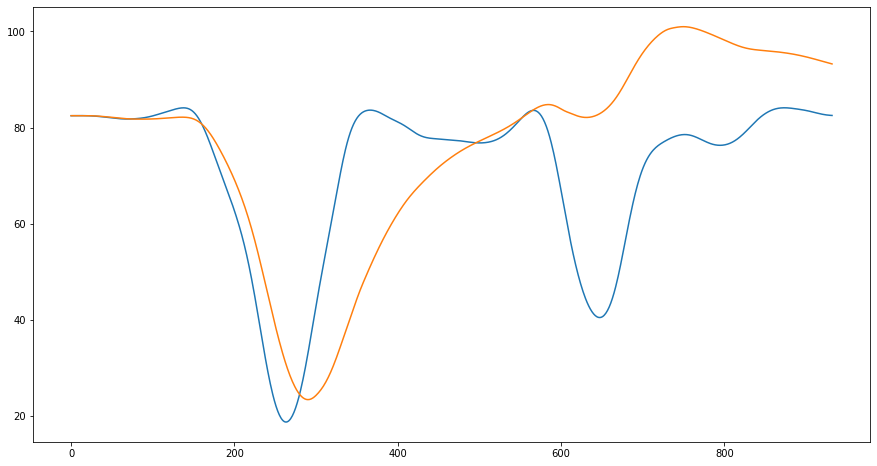

In [86]:
plt.figure(figsize=[15,8])
plt.plot(S)
plt.plot(results[:,0])
#plt.plot(results[:,1])

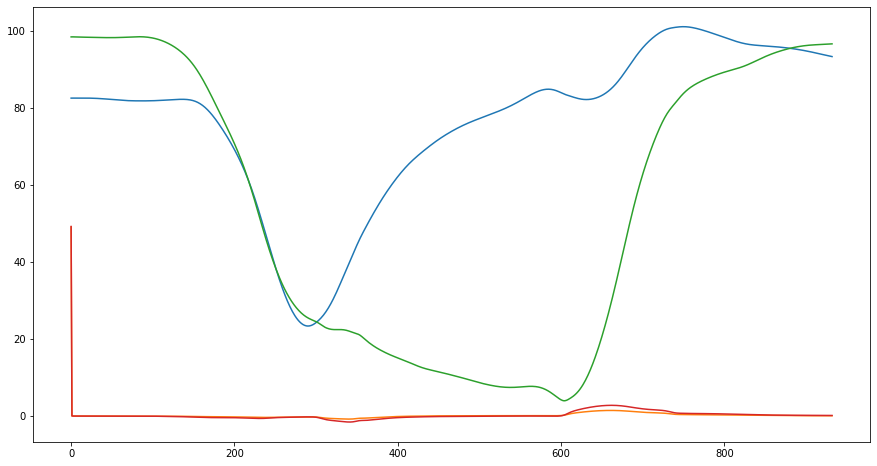

In [87]:
plt.figure(figsize=[15,8])
plt.plot(results)

In [88]:
max((S-results[:,0]))

38.54689470648167

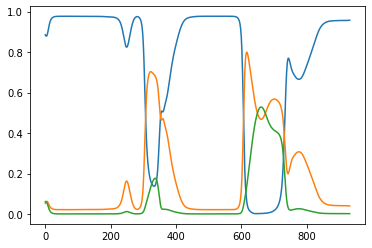

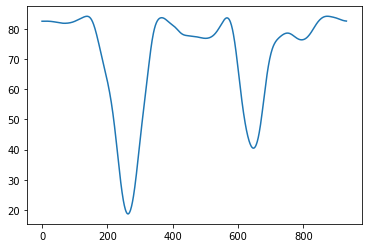

In [89]:
plt.plot(prob_estado)
plt.show()
plt.plot(S)
plt.show()